# Chapter 8

In [30]:
import numpy as np
import random
import pandas as pd
import scipy.stats
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split
import itertools

import matplotlib as plt
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib as mpl
mpl.rc("figure", facecolor="white")
plt.rc('axes', axisbelow=True)
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import pymc3 as pm
import arviz as az

import altair as alt
from vega_datasets import data as data_alt

# data

# H3

In [6]:
rugged = pd.read_csv('../chapter7/rugged.txt', sep=';')
rugged.head(2)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0


In [7]:
rugged.shape

(234, 51)

In [8]:
# pick out the columns that we need
cols = ['country', 'rgdppc_2000', 'rugged', 'cont_africa']
data = rugged[cols]
data.head(2)

,country,rgdppc_2000,rugged,cont_africa
0,Aruba,NaN,0.462,0
1,Afghanistan,NaN,2.518,0


In [9]:
data[data['rgdppc_2000'].isna()].shape

(64, 4)

In [10]:
data[data['rgdppc_2000'].isna()].groupby('cont_africa').size()

cont_africa
0    56
1     8
dtype: int64

In [11]:
data.shape

(234, 4)

In [12]:
# drop the ones that we are missing
data = data[~data['rgdppc_2000'].isna()]
data.head(2)

,country,rgdppc_2000,rugged,cont_africa
2,Angola,1794.729,0.858,1
4,Albania,3703.113,3.427,0


In [13]:
data.shape

(170, 4)

In [14]:
data[data['rugged'].isna()]

,country,rgdppc_2000,rugged,cont_africa


In [15]:
data[data['cont_africa'].isna()]

,country,rgdppc_2000,rugged,cont_africa


In [16]:
# log transform, use natural log to follow what the text did
data['log_gdp'] = data['rgdppc_2000'].apply(lambda x: np.log(x))

In [17]:
data.head(2)

,country,rgdppc_2000,rugged,cont_africa,log_gdp
2,Angola,1794.729,0.858,1,7.492609
4,Albania,3703.113,3.427,0,8.216929


# M1

In [26]:
# original model
with pm.Model() as model_og:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bA = pm.Normal('bA', 0, 10)
    bR = pm.Normal('bR', 0, 10)
    bAR = pm.Normal('bAR', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])
    
    trace_og = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


In [27]:
# new model
with pm.Model() as model_new:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bA = pm.Normal('bA', 0, 10)
    bR = pm.Normal('bR', 0, 10)
    bAR = pm.Normal('bAR', 0, 10)
    sigma = pm.Exponential('sigma', 1)
    
    # deterministic
    mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])
    
    trace_new = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


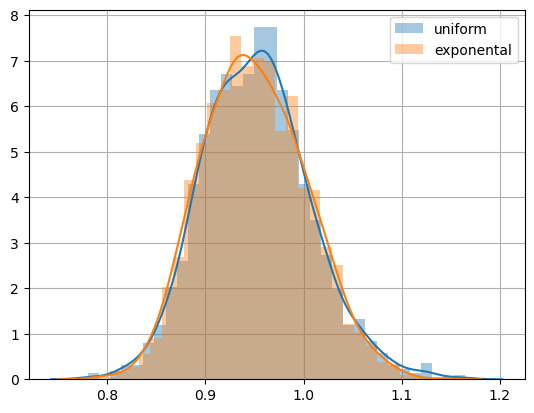

In [38]:
sns.distplot(trace_og['sigma'], label='uniform')
sns.distplot(trace_new['sigma'], label='exponental')

plt.legend()
plt.grid()
plt.show()

# M2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


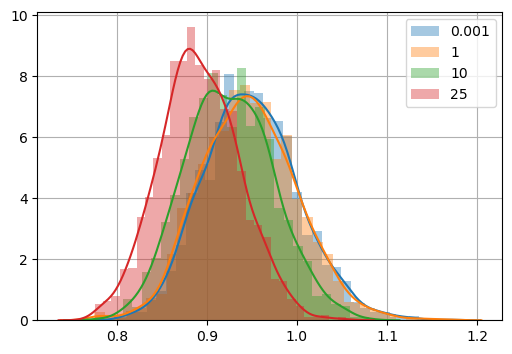

In [63]:
# they are identical; make the scaling parameter different for exp
plt.figure(figsize=(6,4))

for scale in [1e-3, 1, 10, 25]:
    with pm.Model() as model_:
        # priors
        alpha = pm.Normal('alpha', 0, 100)
        bA = pm.Normal('bA', 0, 10)
        bR = pm.Normal('bR', 0, 10)
        bAR = pm.Normal('bAR', 0, 10)
        sigma = pm.Exponential('sigma', scale)

        # deterministic
        mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']

        # likelihood
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])

        trace_ = pm.sample(1000)
        
    sns.distplot(trace_['sigma'], label=str(scale))


plt.legend()
plt.grid()
plt.show() 

In [65]:
# sigma gets smaller as we increase the coeff
# makes sense if you look at what the distribution looks like here:
# https://en.wikipedia.org/wiki/Exponential_distribution

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8791847041244982, but should be close to 0.8. Try to increase the number of tuning steps.


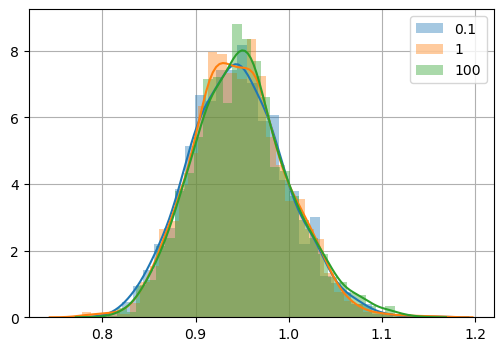

In [66]:
# now evaluate the half cauchy
plt.figure(figsize=(6,4))

for scale in [0.1, 1, 100]:
    with pm.Model() as model_:
        # priors
        alpha = pm.Normal('alpha', 0, 100)
        bA = pm.Normal('bA', 0, 10)
        bR = pm.Normal('bR', 0, 10)
        bAR = pm.Normal('bAR', 0, 10)
        sigma = pm.HalfCauchy('sigma', scale)

        # deterministic
        mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']

        # likelihood
        log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])

        trace_ = pm.sample(1000)
        
    sns.distplot(trace_['sigma'], label=str(scale))


plt.legend()
plt.grid()
plt.show() 

In [67]:
# exact same; half cauchy has fat tails

# M3

In [92]:
# re-estimate one of the models but with a different number of warmup steps
# EZ model
# original model
with pm.Model() as model_og:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bA = pm.Normal('bA', 0, 10)
    bR = pm.Normal('bR', 0, 10)
    bAR = pm.Normal('bAR', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])
    
    trace_og = pm.sample(1000, n_init=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8826382715037805, but should be close to 0.8. Try to increase the number of tuning steps.


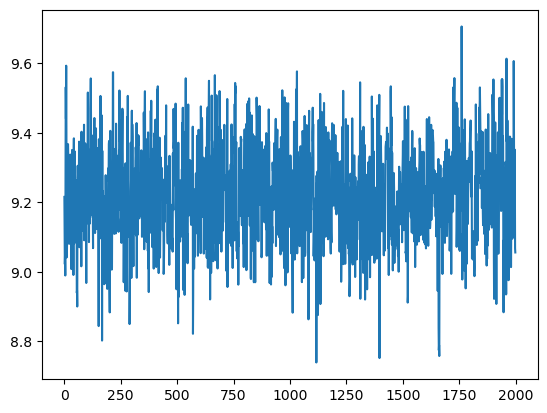

In [93]:
plt.plot(trace_og['alpha'])

In [94]:
pm.summary(trace_og)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.224,0.137,8.968,9.483,0.005,0.003,839.0,839.0,849.0,1097.0,1.0
bA,-1.947,0.226,-2.364,-1.535,0.008,0.006,781.0,775.0,784.0,1385.0,1.0
bR,-0.205,0.079,-0.358,-0.063,0.003,0.002,925.0,898.0,921.0,1203.0,1.0
bAR,0.398,0.129,0.166,0.640,0.004,0.003,851.0,851.0,853.0,1241.0,1.0
sigma,0.951,0.054,0.859,1.063,0.001,0.001,1710.0,1677.0,1760.0,1255.0,1.0


In [95]:
# re-estimate one of the models but with a different number of warmup steps
# EZ model
# original model
with pm.Model() as model_og:
    
    # priors
    alpha = pm.Normal('alpha', 0, 100)
    bA = pm.Normal('bA', 0, 10)
    bR = pm.Normal('bR', 0, 10)
    bAR = pm.Normal('bAR', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    
    # deterministic
    mu = alpha + bA*data['cont_africa'] + bR*data['rugged'] + bAR*data['cont_africa']*data['rugged']
    
    # likelihood
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=data['log_gdp'])
    
    trace_og = pm.sample(1000, n_init=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bR, bA, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


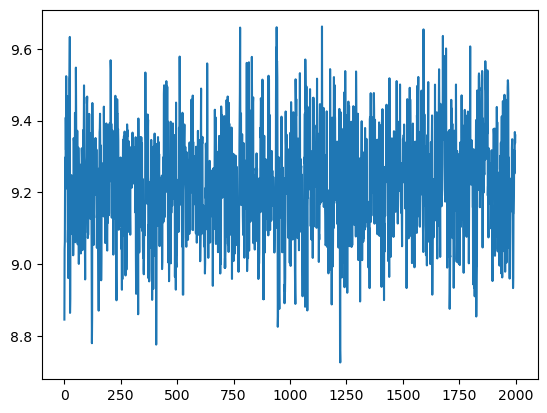

In [96]:
plt.plot(trace_og['alpha'])

In [97]:
pm.summary(trace_og)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.222,0.144,8.953,9.501,0.005,0.004,787.0,786.0,790.0,918.0,1.0
bA,-1.942,0.231,-2.351,-1.489,0.008,0.006,805.0,803.0,810.0,1284.0,1.0
bR,-0.200,0.081,-0.358,-0.048,0.003,0.002,856.0,797.0,861.0,830.0,1.0
bAR,0.391,0.135,0.155,0.655,0.004,0.003,1036.0,1007.0,1039.0,1151.0,1.0
sigma,0.951,0.054,0.852,1.054,0.001,0.001,1355.0,1355.0,1343.0,1172.0,1.0


# H1

In [108]:
# run this model then inspect the posterior distribution and explain what is happening
with pm.Model() as h1:
    # priors
    a = pm.Normal('a', 0, 1)
    b = pm.HalfCauchy('b', 1)
    
    # likelihood
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


(array([  2.,   3.,  39., 154., 359., 473., 480., 341., 106.,  43.]),
 array([-4.11226143, -3.41643017, -2.7205989 , -2.02476763, -1.32893637,
        -0.6331051 ,  0.06272617,  0.75855743,  1.4543887 ,  2.15021997,
         2.84605124]),
 <a list of 10 Patch objects>)

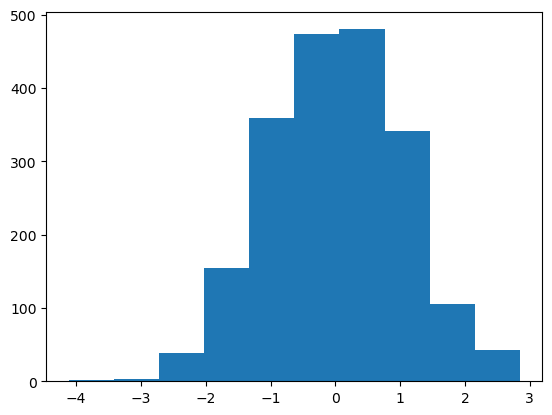

In [109]:
plt.hist(trace['a'])

(array([1.979e+03, 1.300e+01, 3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.04555512e-04, 4.97070543e+01, 9.94138041e+01, 1.49120554e+02,
        1.98827304e+02, 2.48534053e+02, 2.98240803e+02, 3.47947553e+02,
        3.97654303e+02, 4.47361052e+02, 4.97067802e+02]),
 <a list of 10 Patch objects>)

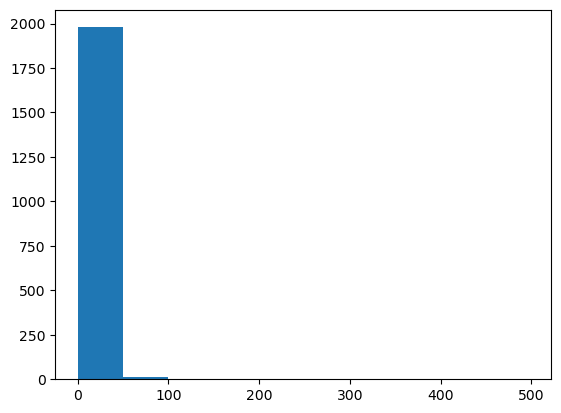

In [110]:
plt.hist(trace['b'])

In [111]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.009,1.029,-1.999,1.792,0.026,0.025,1568.0,846.0,1561.0,1082.0,1.0
b,3.788,16.868,0.000,10.644,0.492,0.348,1177.0,1177.0,1316.0,993.0,1.0


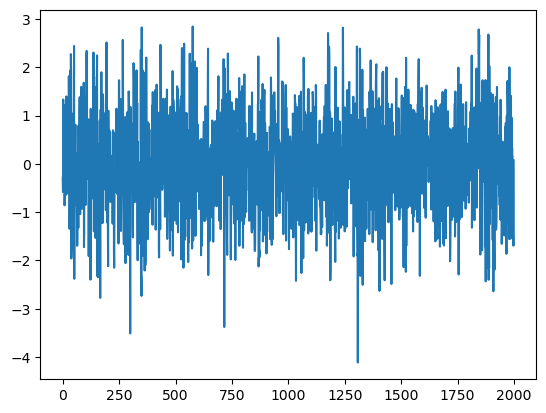

In [113]:
# we are just sampling from the two distributions
plt.plot(trace['a'])

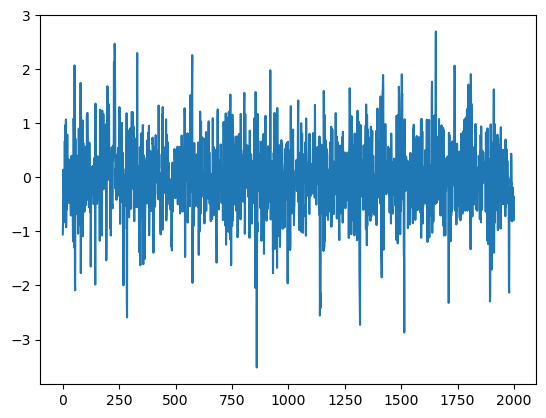

In [115]:
plt.plot(np.log10(trace['b']))

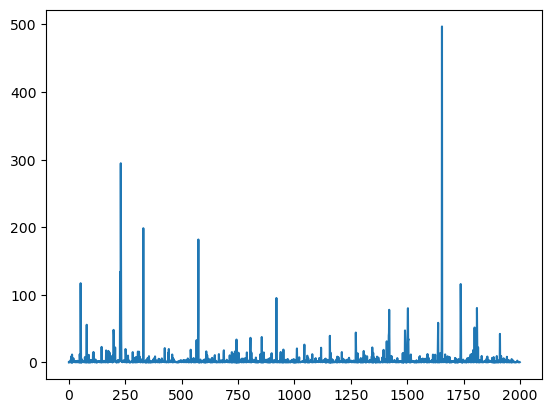

In [116]:
plt.plot(trace['b'])

In [117]:
# half cauch has much bigger tails than normal

# H3

In [132]:
# investigate correlated parameters
# simulate some height data
N = 100
height_obs = np.random.normal(10, 2, N)
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)

In [138]:
# compare two different models
with pm.Model() as model_1:
    # priors
    a = pm.Normal('a', 10, 100)
    bL = pm.Normal('bL', 2, 10)
    bR = pm.Normal('bR', 2, 10)
    sigma = pm.HalfCauchy('sigma', 1)
    
    # deterministic
    mu = a + bL*leg_left + bR*leg_right
    
    # likelihood
    height = pm.Normal('height', mu, sigma, observed=height_obs)
    
    trace_1 = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, bL, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.


In [139]:
with pm.Model() as model_2:
    # priors
    a = pm.Normal('a', 10, 100)
    bL = pm.Normal('bL', 2, 10)
    bR = pm.HalfNormal('bR', sigma=2)
    sigma = pm.HalfCauchy('sigma', 1)
    
    # deterministic
    mu = a + bL*leg_left + bR*leg_right
    
    # likelihood
    height = pm.Normal('height', mu, sigma, observed=height_obs)
    
    trace_2 = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bR, bL, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6936240338146699, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


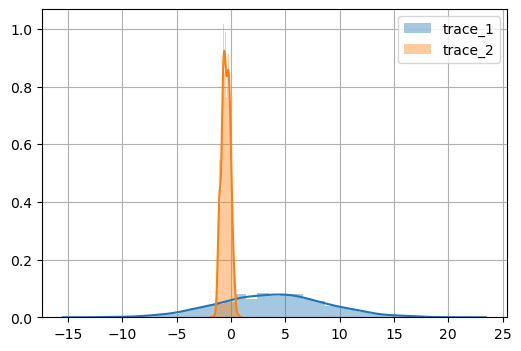

In [140]:
plt.figure(figsize=(6,4))
sns.distplot(trace_1['bL'], label='trace_1')
sns.distplot(trace_2['bL'], label='trace_2')
plt.legend()
plt.grid()
plt.show()

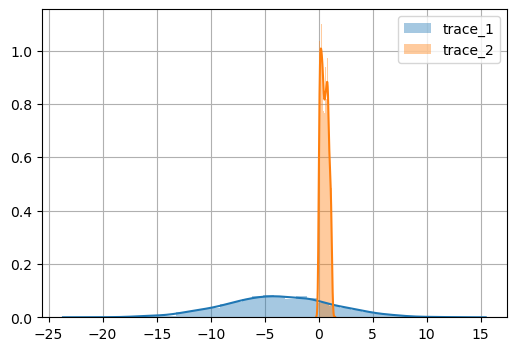

In [141]:
plt.figure(figsize=(6,4))
sns.distplot(trace_1['bR'], label='trace_1')
sns.distplot(trace_2['bR'], label='trace_2')
plt.legend()
plt.grid()
plt.show()

In [142]:
# quite a striking difference
# the difference is due to......
# when you force one to be positive the other must be negative


In [143]:
pm.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.699,1.092,7.598,11.607,0.041,0.030,693.0,670.0,686.0,492.0,1.00
bL,3.822,4.899,-5.148,12.971,0.197,0.140,616.0,609.0,620.0,916.0,1.00
bR,-3.762,4.920,-13.028,5.188,0.198,0.140,618.0,617.0,622.0,867.0,1.00
sigma,1.992,0.143,1.771,2.280,0.005,0.004,751.0,751.0,691.0,389.0,1.01


In [144]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.607,0.945,7.814,11.507,0.050,0.035,360.0,360.0,348.0,522.0,1.03
bL,-0.468,0.385,-1.183,0.175,0.054,0.046,51.0,35.0,52.0,54.0,1.03
bR,0.544,0.337,0.016,1.109,0.049,0.039,48.0,38.0,52.0,50.0,1.02
sigma,1.967,0.152,1.737,2.261,0.019,0.013,67.0,67.0,65.0,236.0,1.03


In [145]:
# wow, 20x less independent samples when you use half cauchy
